# NOAA Weather Bitstream Prototype

This notebook fetches hourly observations from the National Weather Service API, encodes domain-aware weather bits, exports a candle JSON file compatible with the SEP `manifold_generator`, and inspects the resulting coherence/rupture metrics. Configure the station/date below and run the cells sequentially.

## 1. Imports and basic configuration

Set the station identifier (ICAO), target UTC date, and output directory for intermediate artefacts. The script keeps everything inside `analysis/weather/` by default.

In [1]:
from __future__ import annotations

import json
import os
import subprocess
from dataclasses import dataclass
from datetime import datetime, timedelta, timezone
from pathlib import Path
from typing import Any, Dict, Iterable, List

import pandas as pd
import requests

REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent
OUTPUT_ROOT = (REPO_ROOT / "analysis" / "weather")
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

STATION_ID = os.environ.get("NOAA_STATION_ID", "KATT")  # Camp Mabry, Austin
TARGET_DATE = os.environ.get("NOAA_TARGET_DATE", "2025-10-01")  # UTC date
OBS_LIMIT = int(os.environ.get("NOAA_OBS_LIMIT", "500"))  # generous upper bound per API request

print(f"Repository root: {REPO_ROOT}")
print(f"Output directory: {OUTPUT_ROOT}")


Repository root: /workspace/score
Output directory: /workspace/score/analysis/weather


## 2. NOAA API helpers

`fetch_noaa_observations` issues a single request covering the chosen UTC day. The API responds with most-recent-first features, so we sort ascending before returning a tidy `pandas` frame.

In [2]:
USER_AGENT = os.environ.get("NOAA_USER_AGENT", "SEP Weather Signal Prototype (ops@sepengine.com)")
SESSION = requests.Session()
SESSION.headers.update({
    "User-Agent": USER_AGENT,
    "Accept": "application/geo+json",
})

API_ROOT = "https://api.weather.gov"

def utc_bounds(date_str: str) -> tuple[str, str]:
    start = datetime.fromisoformat(date_str).replace(tzinfo=timezone.utc)
    end = start + timedelta(days=1) - timedelta(milliseconds=1)
    return start.isoformat().replace("+00:00", "Z"), end.isoformat().replace("+00:00", "Z")


def fetch_noaa_observations(station: str, date_str: str, limit: int = 1000) -> Dict[str, Any]:
    start, end = utc_bounds(date_str)
    params = {
        "start": start,
        "end": end,
        "limit": min(limit, 1000),
    }
    url = f"{API_ROOT}/stations/{station}/observations"
    resp = SESSION.get(url, params=params, timeout=60)
    resp.raise_for_status()
    return resp.json()


def observations_to_frame(payload: Dict[str, Any]) -> pd.DataFrame:
    features = payload.get("features", [])
    records: List[Dict[str, Any]] = []
    for feat in features:
        props = feat.get("properties", {})
        timestamp = props.get("timestamp")
        if not timestamp:
            continue
        temp = (props.get("temperature") or {}).get("value")
        rh = (props.get("relativeHumidity") or {}).get("value")
        pressure = (props.get("barometricPressure") or {}).get("value")
        if temp is None or rh is None or pressure is None:
            continue
        records.append({
            "time": pd.to_datetime(timestamp),
            "temperature_c": temp,
            "relative_humidity": rh,
            "pressure_pa": pressure,
        })
    if not records:
        raise ValueError("No usable observations in payload")
    frame = pd.DataFrame.from_records(records).dropna()
    frame = frame.sort_values("time").set_index("time")
    frame = frame[~frame.index.duplicated(keep="first")]
    return frame


## 3. Fetch & resample observations

The raw feed may contain sub-hourly updates. We align on a 60-minute grid using median aggregation and forward-fill to cover minor gaps.

In [3]:
payload = fetch_noaa_observations(STATION_ID, TARGET_DATE, limit=OBS_LIMIT)
frame_raw = observations_to_frame(payload)
print(f"Fetched {len(frame_raw)} observations spanning {frame_raw.index.min()} to {frame_raw.index.max()}")

frame_hourly = frame_raw.resample("1H").median().ffill().dropna()
print(f"Hourly samples: {len(frame_hourly)}")
frame_hourly.head()


Fetched 260 observations spanning 2025-10-01 00:00:00+00:00 to 2025-10-01 19:55:00+00:00
Hourly samples: 20


/tmp/ipykernel_112517/2976463368.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  frame_hourly = frame_raw.resample("1H").median().ffill().dropna()


,temperature_c,relative_humidity,pressure_pa
time,,,
2025-10-01 00:00:00+00:00,30.0,42.831581,101388.48
2025-10-01 01:00:00+00:00,29.0,45.374280,101422.34
2025-10-01 02:00:00+00:00,28.0,48.088386,101456.20
2025-10-01 03:00:00+00:00,27.0,54.334416,101490.06
2025-10-01 04:00:00+00:00,26.0,61.388520,101490.06


## 4. Encode trend bits and composite signal

The bits follow the SEP/QFH weather sketch:

- Temperature bit = 1 when temperature is non-decreasing.
- Humidity bit = 1 when humidity is non-decreasing.
- Pressure bit = 1 when pressure is falling.
- Composite bit = majority vote across the three trends.

In [4]:
def compute_bits(frame: pd.DataFrame) -> pd.DataFrame:
    df = frame.copy()
    df["temp_bit"] = (df["temperature_c"] >= df["temperature_c"].shift(1)).astype(int)
    df["hum_bit"] = (df["relative_humidity"] >= df["relative_humidity"].shift(1)).astype(int)
    df["press_bit"] = (df["pressure_pa"] < df["pressure_pa"].shift(1)).astype(int)
    df["composite_bit"] = (df[["temp_bit", "hum_bit", "press_bit"]].sum(axis=1) >= 2).astype(int)
    df = df.dropna()
    return df

bits_frame = compute_bits(frame_hourly)
print(bits_frame[["temp_bit", "hum_bit", "press_bit", "composite_bit"]].tail())
print(f"Composite bits: {bits_frame['composite_bit'].tolist()}")

                           temp_bit  hum_bit  press_bit  composite_bit
time                                                                  
2025-10-01 15:00:00+00:00         1        0          0              0
2025-10-01 16:00:00+00:00         1        0          0              0
2025-10-01 17:00:00+00:00         1        0          1              1
2025-10-01 18:00:00+00:00         1        0          1              1
2025-10-01 19:00:00+00:00         1        0          1              1
Composite bits: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]


## 5. Convert composite bits into candle JSON

`manifold_generator` expects OHLCV candles. We synthesise candles where price moves up when the composite bit is 1 and down otherwise, with monotonically increasing volume to keep the derived QFH bit aligned with the composite sequence.

In [5]:
def bits_to_candles(bits_df: pd.DataFrame, base_value: float = 0.0) -> List[Dict[str, Any]]:
    candles: List[Dict[str, Any]] = []
    if bits_df.empty:
        return candles
    first_time = bits_df.index[0] - timedelta(hours=1)
    prev_close = base_value
    prev_volume = 1000.0
    candles.append({
        "timestamp": int(first_time.timestamp() * 1000),
        "open": prev_close,
        "high": prev_close + 0.1,
        "low": prev_close - 0.1,
        "close": prev_close,
        "volume": prev_volume,
    })

    for ts, row in bits_df.iterrows():
        bit = int(row["composite_bit"])
        open_price = prev_close
        delta = 1.0 if bit == 1 else -1.0
        close_price = open_price + delta
        high = max(open_price, close_price) + 0.05
        low = min(open_price, close_price) - 0.05
        prev_volume += 1.0
        candle = {
            "timestamp": int(ts.timestamp() * 1000),
            "open": float(open_price),
            "high": float(high),
            "low": float(low),
            "close": float(close_price),
            "volume": float(prev_volume),
        }
        candles.append(candle)
        prev_close = close_price
    return candles

candles = bits_to_candles(bits_frame)
print(f"Generated {len(candles)} candles")

candle_path = OUTPUT_ROOT / f"{STATION_ID}_{TARGET_DATE}.candles.json"
with candle_path.open("w", encoding="utf-8") as handle:
    json.dump(candles, handle, indent=2)

print(f"Candles written to {candle_path}")

candles[:3]


Generated 21 candles
Candles written to /workspace/score/analysis/weather/KHOU_2025-10-01.candles.json


[{'timestamp': 1759273200000,
  'open': 0.0,
  'high': 0.1,
  'low': -0.1,
  'close': 0.0,
  'volume': 1000.0},
 {'timestamp': 1759276800000,
  'open': 0.0,
  'high': 0.05,
  'low': -1.05,
  'close': -1.0,
  'volume': 1001.0},
 {'timestamp': 1759280400000,
  'open': -1.0,
  'high': -0.95,
  'low': -2.05,
  'close': -2.0,
  'volume': 1002.0}]

## 6. Run the native manifold generator

We invoke the compiled `bin/manifold_generator`, pointing it at the candle JSON. The command writes a manifold snapshot for inspection.

In [6]:
manifold_path = OUTPUT_ROOT / f"{STATION_ID}_{TARGET_DATE}.manifold.json"
cmd = [str(REPO_ROOT / "bin" / "manifold_generator"), "--input", str(candle_path), "--output", str(manifold_path)]
print("Running:", " ".join(cmd))
result = subprocess.run(cmd, check=False, capture_output=True, text=True)
print("stdout:", result.stdout)
print("stderr:", result.stderr)
if result.returncode != 0:
    raise RuntimeError(f"manifold_generator failed with exit code {result.returncode}")
print(f"Manifold stored at {manifold_path}")


Running: /workspace/score/bin/manifold_generator --input /workspace/score/analysis/weather/KHOU_2025-10-01.candles.json --output /workspace/score/analysis/weather/KHOU_2025-10-01.manifold.json
stdout: [2025-10-01 15:20:58.735] [info] Wrote manifold JSON to /workspace/score/analysis/weather/KHOU_2025-10-01.manifold.json

stderr: 
Manifold stored at /workspace/score/analysis/weather/KHOU_2025-10-01.manifold.json


## 7. Inspect λ / rupture metrics

Load the manifold JSON and examine the most recent signal to confirm hazard values respond to the composite bit flips.

In [7]:
with manifold_path.open("r", encoding="utf-8") as handle:
    manifold = json.load(handle)

signals = manifold.get("signals", [])
print(f"Signal count: {len(signals)}")

if signals:
    last = signals[-1]
    metrics = last.get("metrics", {})
    display({
        "timestamp_ns": last.get("timestamp_ns"),
        "signature": last.get("repetition", {}).get("signature"),
        "coherence": metrics.get("coherence"),
        "stability": metrics.get("stability"),
        "entropy": metrics.get("entropy"),
        "rupture": metrics.get("rupture"),
        "lambda_hazard": last.get("lambda_hazard", metrics.get("rupture")),
        "count_1h": last.get("repetition", {}).get("count_1h"),
    })
else:
    print("No signals emitted. Check the candle payload length.")

Signal count: 9


{'timestamp_ns': 1759305600000000000,
 'signature': 'c0.22_s0.55_e0.94',
 'coherence': 0.2229540227861495,
 'stability': 0.5454545319080353,
 'entropy': 0.9431664272954218,
 'rupture': 0.4545454680919647,
 'lambda_hazard': 0.4545454680919647,
 'count_1h': 1}

## 8. Optional: plot composite bits vs hazard

Visualise the composite bit timeline alongside rupture/λ to spot transitions.

Saved plot to /workspace/score/analysis/weather/KHOU_2025-10-01_lambda.png


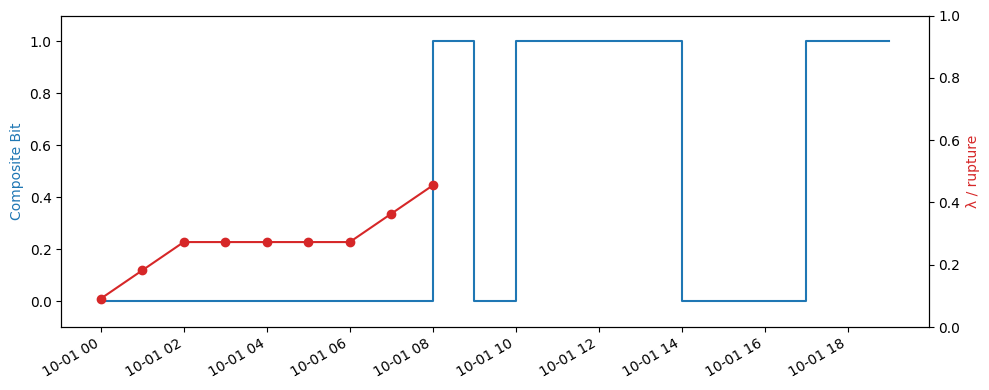

In [8]:
import matplotlib.pyplot as plt

if signals:
    signal_frame = pd.DataFrame([{**sig.get("metrics", {}), "lambda_hazard": sig.get("lambda_hazard"), "timestamp_ns": sig.get("timestamp_ns")}
                                 for sig in signals])
    signal_frame["timestamp"] = pd.to_datetime(signal_frame["timestamp_ns"], unit="ns", utc=True)
    merged = bits_frame.reset_index()
    timestamp_col = merged.columns[0]
    merged = merged.rename(columns={timestamp_col: "timestamp"})
    merged["timestamp"] = pd.to_datetime(merged["timestamp"], utc=True)
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.step(merged["timestamp"], merged["composite_bit"], where="post", label="Composite Bit", color="tab:blue")
    ax1.set_ylabel("Composite Bit", color="tab:blue")
    ax1.set_ylim(-0.1, 1.1)
    ax2 = ax1.twinx()
    ax2.plot(signal_frame["timestamp"], signal_frame["lambda_hazard"], marker="o", label="λ", color="tab:red")
    ax2.set_ylabel("λ / rupture", color="tab:red")
    ax2.set_ylim(0, 1)
    fig.autofmt_xdate()
    fig.tight_layout()
    plot_path = OUTPUT_ROOT / f"{STATION_ID}_{TARGET_DATE}_lambda.png"
    fig.savefig(plot_path, dpi=150, bbox_inches="tight")
    print(f"Saved plot to {plot_path}")
    plt.show()
else:
    print("Skipping plot—no manifold signals available.")
